# 100. CIFAR-10 을 이용한 CNN 구축

- **CNN**을 학습하여 CIFAR-10 데이터베이스의 이미지를 분류합니다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import torch.nn.functional as F

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")   # NVIDIA GPU
elif torch.backends.mps.is_available():
    device = torch.device("mps")      # Apple Silicon GPU (M1/M2/M3)
else:
    device = torch.device("cpu")      # CPU only

print("Using device:", device)

Using device: mps


## Data Download 및 Data Loader 를 이용하여 Train, Validation data 준비

transforms.ToTensor()의 주요 특징:

1) 데이터 타입 변환: PIL 이미지나 NumPy ndarray를 torch.FloatTensor로 변환  
2) 스케일링: 이미지의 픽셀 값 범위를 [0, 255]에서 [0.0, 1.0]으로 스케일링  
3) 차원 재배열: PyTorch에서는 이미지 데이터를 [C, H, W] 형식(채널, 높이, 너비)으로 처리하므로 입력 이미지 데이터의 차원을 이 형식으로 자동 재배열

In [3]:
BATCH_SIZE = 32
PIN_MEMORY = False

# 이미지 데이터에 대한 변환(transform) 조합을 정의
# 이 변환은 이미지 데이터를 증강(augmentation)하고 전처리하는 과정을 포함합니다.
composed = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR10 훈련 데이터셋을 다운로드하고, 위에서 정의한 변환을 적용
train_data = datasets.CIFAR10(root = './data',
                              train = True,
                              download = True,
                              transform = composed)

# CIFAR10 테스트 데이터셋을 다운로드하고, 위에서 정의한 변환을 적용
test_data = datasets.CIFAR10(root='./data',
                             train = False,
                             download=True,
                             transform=composed)

if device == 'cuda:0':
    PIN_MEMORY = True

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size = BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=PIN_MEMORY
)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size = BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=PIN_MEMORY
)

In [4]:
print(train_data)
print()
print(test_data)
print()
print(train_data[0][0].shape)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

torch.Size([3, 32, 32])


In [5]:
# CIFAR-10은 10개의 서로 다른 객체 클래스를 포함하는 이미지 데이터셋입니다.
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### 일부 Data 시각화

- matplotlib 은 channel 위치가 last 이므로 transpose(1, 2, 0) 로 image 수정

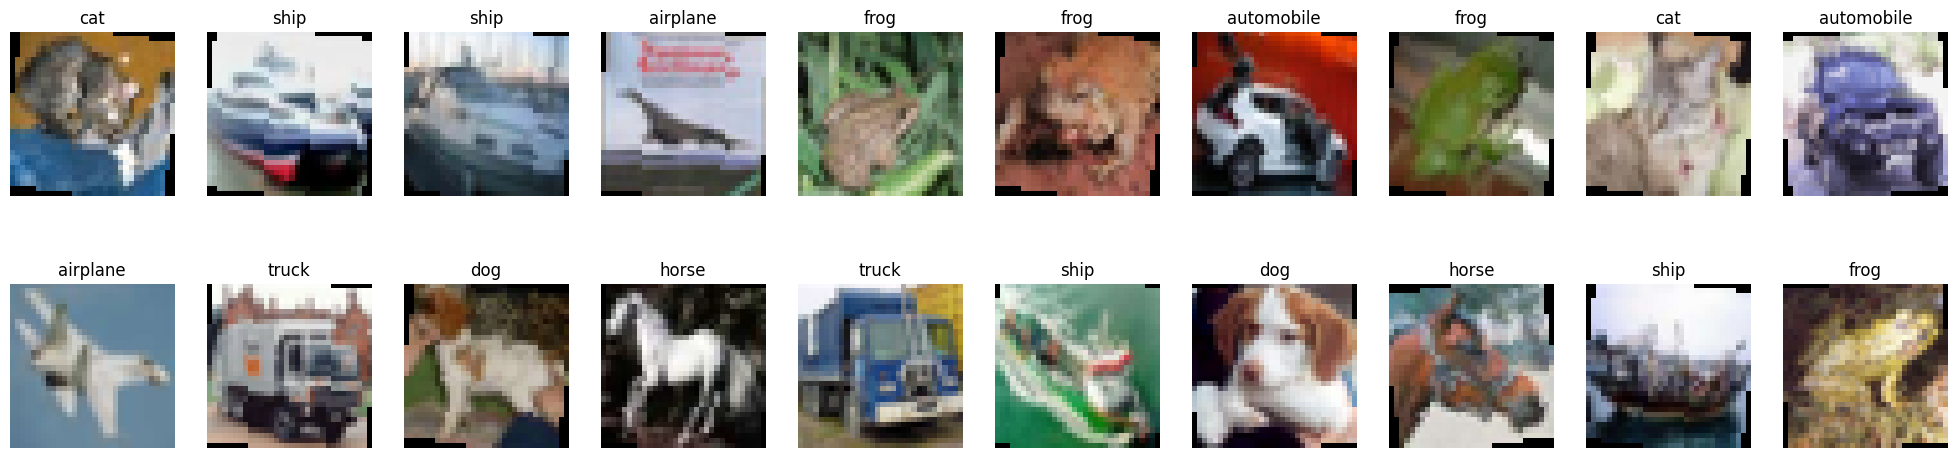

In [6]:
plt.figure(figsize=(25, 6))
for i, (x, y) in enumerate(test_data):
    if i > 19:
        break
    plt.subplot(2, 10, i + 1)
    # np.transpose 함수를 사용하여 'x' 텐서의 차원을 재배열
    # (1, 2, 0)은 채널 차원을 마지막으로 이동시키고, 높이와 너비 차원을 앞으로 가져옵니다.
    # 이 형식은 matplotlib와 같은 일부 라이브러리에서 이미지를 표시할 때 요구되는 형식입니다.
    # * 0.5 + 0.5 연산은 정규화를 되돌려 픽셀 값을 원본 범위(0~1)로 unnormalize
    img = x.permute(1, 2, 0) * 0.5 + 0.5

    plt.imshow(img)
    plt.title(cifar10_classes[y])
    plt.axis('off')
plt.show()

## Model build

### Custom Model

- Output Size = (W - F + 2P) / S + 1  
- output_size / Maxpool(2)

In [7]:
import math

def output_size(W, F, P, S):
    """
    합성곱(Convolution) 또는 풀링(Pooling) 연산 후 출력 feature map 크기를 계산하는 함수

    매개변수:
    W : 입력 feature map의 크기 (width 또는 height)
    F : 필터(커널) 크기
    P : 패딩(padding) 크기
    S : 스트라이드(stride) 크기

    반환값:
    연산 후 출력 feature map의 크기 (정수, floor 적용)
    
    공식:
    out = floor((W - F + 2P) / S) + 1
    """
    return math.floor((W - F + 2*P) / S) + 1

# Conv -> Pooling 순서
conv_out = output_size(32, 3, 1, 1)       # Conv 출력 = 32
pool_out = output_size(conv_out, 2, 0, 2) # Pool 출력 = 16
print(conv_out, pool_out)

32 16


input image size : (32, 32)  
kernel size : 3  
padding : 1  
stride : 1

In [8]:
# CNN의 출력 크기 변화를 단계별로 계산
conv_out1 = output_size(32, 3, 1, 1)
pool_out1 = output_size(conv_out1, 2, 0, 2)
print(pool_out1)

conv_out2 = output_size(pool_out1, 3, 1, 1)
pool_out2 = output_size(conv_out2, 2, 0, 2)
print(pool_out2)

conv_out3 = output_size(pool_out2, 3, 1, 1)
pool_out3 = output_size(conv_out3, 2, 0, 2)
print(pool_out3)

16
8
4


In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # 3개의 입력 채널을 받아 16개의 출력 채널을 생성
        # 커널 크기는 3, 패딩은 1로 설정하여 입력 이미지의 크기를 유지합니다.
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(16)

        # 16개의 입력 채널을 받아 32개의 출력 채널을 생성
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(32)

        # 32개의 입력 채널을 받아 64개의 출력 채널을 생성
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3_bn = nn.BatchNorm2d(64)

        # 첫 번째 완전 연결 층을 정의합니다. 입력 특징의 수는 4*4*64, 출력 특징의 수는 256입니다.
        self.fc1 = nn.Linear(4 * 4 * 64, 256)
        self.fc1_bn = nn.BatchNorm1d(256)

        # 두 번째 완전 연결 층을 정의합니다. 10개의 출력 클래스에 대응합니다.
        self.fc2 = nn.Linear(256, 10)

        self.maxpool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # 합성곱 층과 배치 정규화, ReLU 활성화 함수, 최대 풀링을 차례로 적용
        x = self.relu(self.conv1_bn(self.conv1(x)))
        x = self.maxpool(x)
        x = self.relu(self.conv2_bn(self.conv2(x)))
        x = self.maxpool(x)
        x = self.relu(self.conv3_bn(self.conv3(x)))
        x = self.maxpool(x)

        # 특징 맵을 1차원으로 평탄화
        x = x.view(x.size(0), -1)

        # 드롭아웃 적용
        x = self.dropout(x)

        # 완전 연결 층과 배치 정규화, ReLU 활성화 함수 적용
        x = self.relu(self.fc1_bn(self.fc1(x)))
    
        # 최종 출력 계산
        x = self.fc2(x)

        return x

In [10]:
model = Net().to(device)

### Model Summary

In [11]:
model

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc1_bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)

In [12]:
print('model parameters:', sum(p.numel() for p in model.parameters()))

model parameters: 289290


In [13]:
from torchinfo import summary

summary(model, input_size=(1, 3, 32, 32), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 32, 32]           448
├─BatchNorm2d: 1-2                       [1, 16, 32, 32]           32
├─ReLU: 1-3                              [1, 16, 32, 32]           --
├─MaxPool2d: 1-4                         [1, 16, 16, 16]           --
├─Conv2d: 1-5                            [1, 32, 16, 16]           4,640
├─BatchNorm2d: 1-6                       [1, 32, 16, 16]           64
├─ReLU: 1-7                              [1, 32, 16, 16]           --
├─MaxPool2d: 1-8                         [1, 32, 8, 8]             --
├─Conv2d: 1-9                            [1, 64, 8, 8]             18,496
├─BatchNorm2d: 1-10                      [1, 64, 8, 8]             128
├─ReLU: 1-11                             [1, 64, 8, 8]             --
├─MaxPool2d: 1-12                        [1, 64, 4, 4]             --
├─Drop

### Loss Function

In [14]:
# 학습률(Learning Rate) 설정
lr = 0.01

# 손실 함수(Loss Function) 정의
criterion = nn.CrossEntropyLoss()

# 옵티마이저(Optimizer) 설정
# - momentum=0.9: 관성을 부여하여 최적화 속도를 높이는 모멘텀 설정
# - weight_decay=1e-4: 가중치 감소(Weight Decay)로 L2 정규화 적용 (과적합 방지) -> λ
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)

In [15]:
from tqdm import tqdm

LOSS, VAL_LOSS, ACC, VAL_ACC = [], [], [], []

EPOCH = 10 

for epoch in range(EPOCH):
    model.train()

    train_loss = 0 # 한 에폭에서의 훈련 손실 누적값 초기화
    train_acc = 0  # 한 에폭에서의 훈련 정확도 누적값 초기화
    for data, target in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCH}"):
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad() # 이전 그래디언트 초기화
        logits = model(data)
        loss = criterion(logits, target) 

        train_loss += loss.item() # 손실 누적
        pred = logits.argmax(1)
        train_acc += (pred == target).sum().item() # 정확히 예측된 개수 누적
        
        loss.backward() # 손실에 대한 그레디언트 계산
        optimizer.step() # 모델의 가중치 업데이트

    # 평균 손실 및 정확도 계산
    train_loss /= len(train_data)
    train_acc /= len(train_data)

    # 에폭별 훈련 및 검증 결과 출력
    LOSS.append(train_loss)
    ACC.append(train_acc)

    model.eval() 
    
    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            
            logits = model(data)
            loss = criterion(logits, target)

            val_loss += loss.item()
            pred = logits.argmax(1)
            val_acc += (pred == target).sum().item()

    val_loss /= len(test_data)
    val_acc /= len(test_data)

    VAL_LOSS.append(val_loss)
    VAL_ACC.append(val_acc)

    print(f'epoch {epoch + 1} ==> train loss: {train_loss:.5f}, validation loss: {val_loss:.5f}, train acc: {train_acc:.5f}, validation acc: {val_acc:.5f}')

Epoch 1/10: 100%|██████████| 1563/1563 [00:23<00:00, 67.90it/s] 


epoch 1 ==> train loss: 0.04285, validation loss: 0.03341, train acc: 0.50688, validation acc: 0.62210


Epoch 2/10: 100%|██████████| 1563/1563 [00:22<00:00, 68.65it/s] 


epoch 2 ==> train loss: 0.03352, validation loss: 0.02879, train acc: 0.61814, validation acc: 0.67440


Epoch 3/10: 100%|██████████| 1563/1563 [00:23<00:00, 67.70it/s] 


epoch 3 ==> train loss: 0.02996, validation loss: 0.02580, train acc: 0.66092, validation acc: 0.70900


Epoch 4/10: 100%|██████████| 1563/1563 [00:23<00:00, 66.87it/s] 


epoch 4 ==> train loss: 0.02758, validation loss: 0.02477, train acc: 0.69036, validation acc: 0.72310


Epoch 5/10: 100%|██████████| 1563/1563 [00:23<00:00, 67.03it/s] 


epoch 5 ==> train loss: 0.02599, validation loss: 0.02422, train acc: 0.70916, validation acc: 0.73020


Epoch 6/10: 100%|██████████| 1563/1563 [00:22<00:00, 68.08it/s] 


epoch 6 ==> train loss: 0.02459, validation loss: 0.02322, train acc: 0.72282, validation acc: 0.74060


Epoch 7/10: 100%|██████████| 1563/1563 [00:22<00:00, 69.66it/s] 


epoch 7 ==> train loss: 0.02384, validation loss: 0.02180, train acc: 0.73092, validation acc: 0.75750


Epoch 8/10: 100%|██████████| 1563/1563 [00:23<00:00, 67.20it/s] 


epoch 8 ==> train loss: 0.02303, validation loss: 0.02206, train acc: 0.74202, validation acc: 0.75440


Epoch 9/10: 100%|██████████| 1563/1563 [00:22<00:00, 68.83it/s] 


epoch 9 ==> train loss: 0.02222, validation loss: 0.02082, train acc: 0.75032, validation acc: 0.76790


Epoch 10/10: 100%|██████████| 1563/1563 [00:22<00:00, 69.69it/s] 


epoch 10 ==> train loss: 0.02170, validation loss: 0.02085, train acc: 0.75698, validation acc: 0.76490


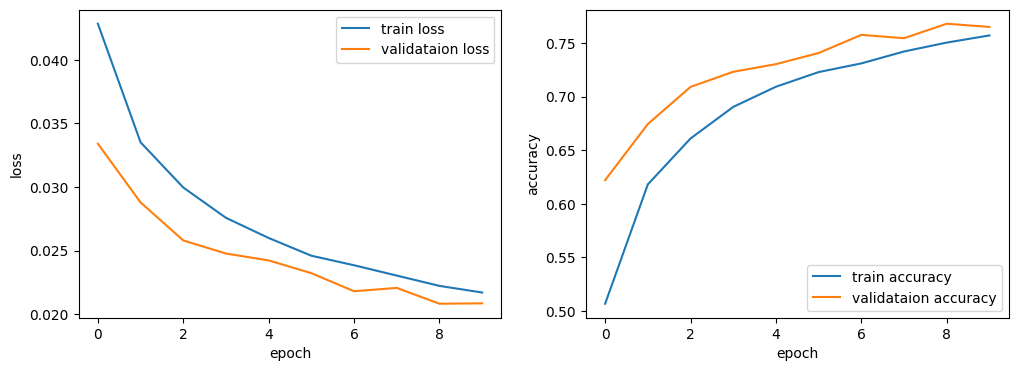

In [16]:
# 1행 2열(subplot 2개)짜리 그래프 생성, 전체 크기는 (12, 4)
# (왼쪽 그래프) 학습 손실(train loss)과 검증 손실(validation loss) 그래프
# (오른쪽 그래프) 학습 정확도(train accuracy)와 검증 정확도(validation accuracy) 그래프
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(LOSS, label='train loss')
axes[0].plot(VAL_LOSS, label='validataion loss')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[0].legend()

axes[1].plot(ACC, label='train accuracy')
axes[1].plot(VAL_ACC, label='validataion accuracy')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')
axes[1].legend()
plt.show()

### Model 평가

### model 이 어떤 image 들을 잘 맞추고 혹은 틀렸는지 시각화

In [17]:
predictions = []
labels = []

model.eval()

with torch.inference_mode():
    # 테스트 데이터셋을 배치 단위로 순회
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        
        logits = model(data)
        pred = logits.argmax(1)
        predictions.extend(pred.numpy(force=True))
        labels.extend(target.numpy(force=True))

# 예측값과 실제 레이블이 일치하는 경우의 인덱스를 찾음
correct_indices = np.nonzero(np.array(predictions) == np.array(labels))[0]

# 예측값과 실제 레이블이 불일치하는 경우의 인덱스를 찾음
incorrect_indices = np.nonzero(np.array(predictions) != np.array(labels))[0]

# 정확도 계산: 정확한 예측의 수를 전체 예측의 수로 나눈 후 100을 곱하여 백분율로 변환
accuracy = len(correct_indices) / len(predictions) * 100
print(f'accuracy = {accuracy:.2f}%')

accuracy = 76.48%


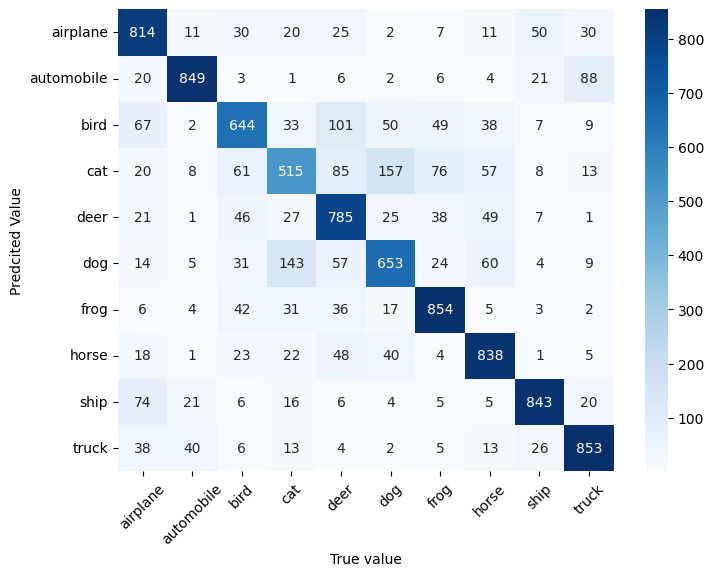

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 혼동 행렬(Confusion Matrix) 계산
cm = confusion_matrix(labels, predictions)

# 혼동 행렬 시각화 (히트맵 형태)
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                 xticklabels=cifar10_classes,
                 yticklabels=cifar10_classes)

# 축(label) 설정
ax.set_xlabel('True value')
ax.set_ylabel('Predcited Value')

# x축 틱 레이블을 45도 회전하여 가독성 향상
plt.xticks(rotation=45)

plt.show()

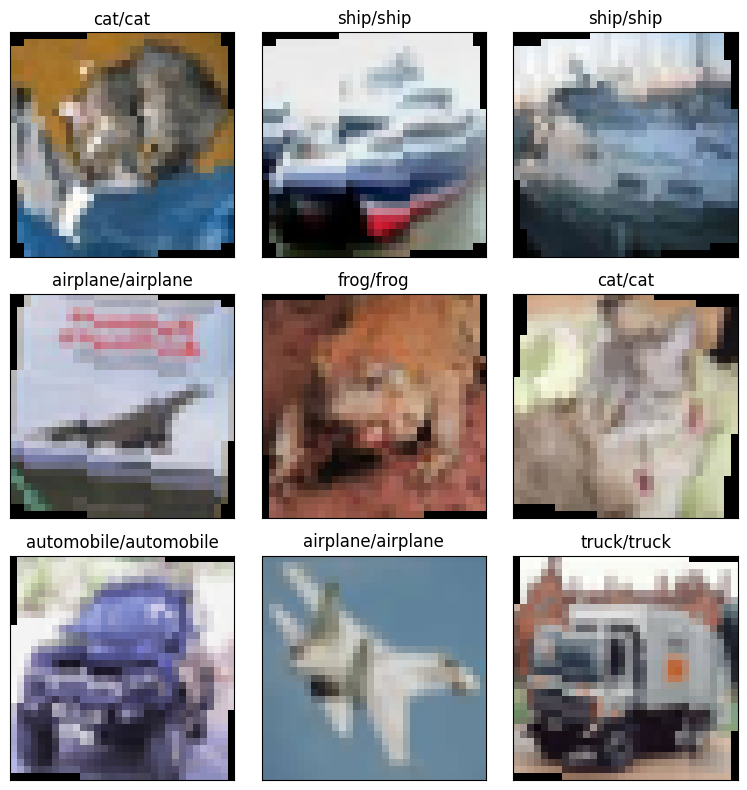

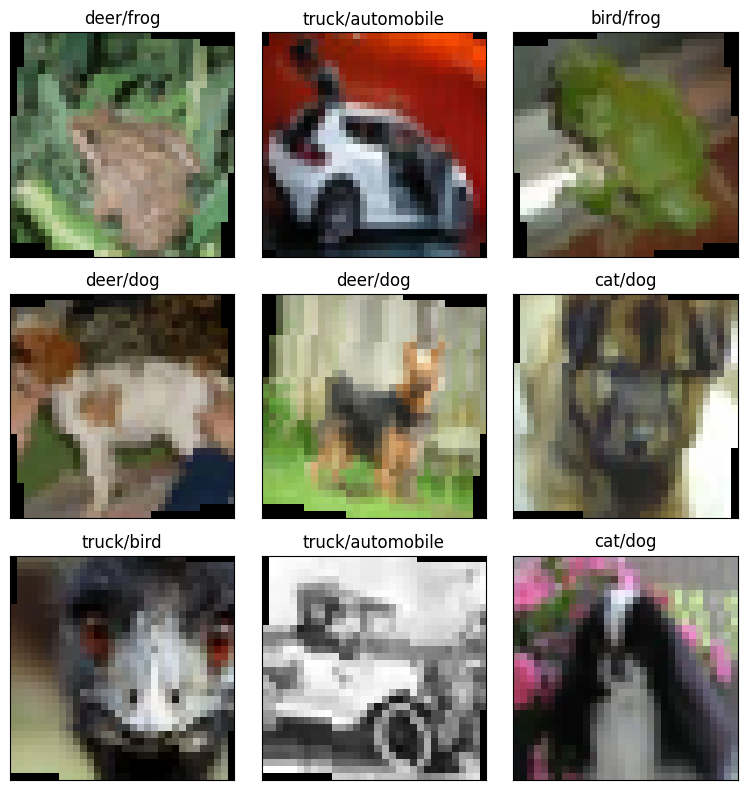

In [19]:
plt.figure(figsize=(8, 8))
# 정확한 예측의 인덱스에서 처음 9개를 순회합니다.
for i, idx in enumerate(correct_indices[:9]):
    plt.subplot(3, 3, i+1)
    img = np.transpose(test_data[idx][0], (1, 2, 0)) / 2 + 0.5  # 이미지 정규화를 되돌리고, 차원을 재배열
    plt.imshow(img)
    plt.title("{}/{}".format(cifar10_classes[predictions[idx]], cifar10_classes[labels[idx]]))  # 예측 레이블/실제 레이블을 제목으로 표시
    plt.xticks([])  # x축 눈금 제거
    plt.yticks([])  # y축 눈금 제거
    plt.tight_layout()  # 서브플롯 간격을 자동으로 조정

plt.figure(figsize=(8, 8))
 # 잘못된 예측의 인덱스에서 처음 9개를 순회합니다.
for i, idx in enumerate(incorrect_indices[:9]):
    plt.subplot(3, 3, i+1)
    img = np.transpose(test_data[idx][0], (1, 2, 0)) / 2 + 0.5
    plt.imshow(img)
    plt.title("{}/{}".format(cifar10_classes[predictions[idx]], cifar10_classes[labels[idx]]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

## 모델 저장 및 불러오기  

### `state_dict` 를 사용하여 모델 저장 및 불러오기  

In [20]:
# 학습이 끝난 후 모델 가중치 저장
torch.save(model.state_dict(), 'cifar10-cnn.pth')
print('학습된 모델 가중치가 저장되었습니다.')

학습된 모델 가중치가 저장되었습니다.


In [21]:
# 같은 모델 구조를 가진 새로운 모델 생성
reload_1 = Net().to(device)

# 저장된 가중치 로드
reload_1.load_state_dict(torch.load('cifar10-cnn.pth'))
print('저장된 모델 가중치를 성공적으로 로드했습니다.')

저장된 모델 가중치를 성공적으로 로드했습니다.


In [22]:
# 로드한 모델의 성능 테스트
reload_predictions = []
reload_labels = []

reload_1.eval()

with torch.inference_mode():
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)

        logits = reload_1(data)
        pred = logits.argmax(1)
        reload_predictions.extend(pred.numpy(force=True))
        reload_labels.extend(target.numpy(force=True))

# 정확도 계산
reload_accuracy = np.mean(np.array(reload_predictions) == np.array(reload_labels)) * 100
print(f"Reloaded model accuracy = {reload_accuracy:.2f}%")

Reloaded model accuracy = 77.11%
